导入必要的包

In [7]:
import nori2 as nori
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pprint import pprint
import torch
import numpy as np
import sys
sys.path.append('../')
from data.datasets.veri776 import VeRi776Nori
from exp.exp_utils import read_nori_image, get_simmilarity_matrix


读取数据信息


In [8]:
nr = nori.open('s3://normal/veri776/image_train.nori', 'r')

metas = []
for nori_id, data, meta in nr.scan(scan_data=False):
    fname = meta['filename']
    meta['vid'] = int(fname.split('/')[1].split('_')[0])
    meta['cam_id'] = int(fname.split('/')[1].split('_')[1][1:])
    metas.append(meta)
    
pprint(metas[0])


{'CreateDate': 1550157703,
 'DataID': '2084102,1000066998b4',
 'cam_id': 1,
 'filename': 'image_train/0454_c001_00011970_0.jpg',
 'size': 12271,
 'vid': 454}


求解相似度矩阵


In [9]:
dataset = VeRi776Nori()
centerloss_checkout_ckpt = torch.load('../veri776_train_output/resnet50_centerloss_120.pth', map_location='cpu')
center_vecs = centerloss_checkout_ckpt['centers']  # 576, 2048
cos_similarity_matrix = get_simmilarity_matrix(center_vecs)
softmax_cos_similarity_mat = torch.softmax(cos_similarity_matrix, 1)

=> VeRi776 loaded
Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   576 |    37778 |        20
  query    |   200 |     1678 |        19
  gallery  |   200 |    11579 |        19
  ----------------------------------------


查询

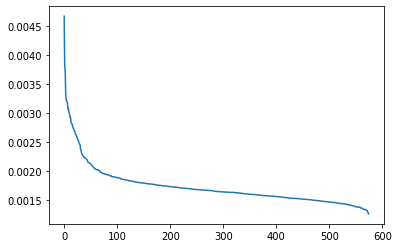

In [12]:
query_index = 200
similarity, rank = torch.sort(softmax_cos_similarity_mat[query_index][1:], descending=True)
plt.plot(np.arange(len(rank.numpy())), similarity.numpy())
plt.show()

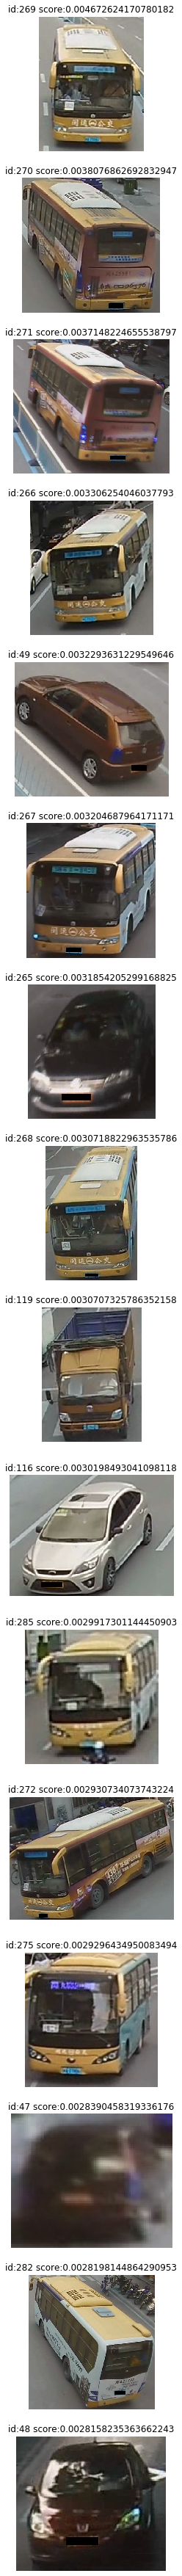

In [18]:
pids = [dataset.train_label2pid[label.item()] for label in rank]
fig, axs = plt.subplots(16, figsize=(4, 4*16))
for i, vid in enumerate(pids[:16]):
    metas_vid = [meta for meta in metas if meta['vid'] == vid]
    img = read_nori_image(metas_vid[0]['DataID'])
    axs[i].imshow(img)
    axs[i].set_title('id:{} score:{}'.format(vid, similarity[i]))
    axs[i].axis('off')
plt.show()

In [78]:
print(similarity)

tensor([0.0047, 0.0031, 0.0030, 0.0028, 0.0027, 0.0027, 0.0027, 0.0026, 0.0026,
        0.0026, 0.0025, 0.0025, 0.0024, 0.0024, 0.0023, 0.0023, 0.0023, 0.0022,
        0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022,
        0.0022, 0.0022, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0018, 

In [79]:
torch.save(softmax_cos_similarity_mat, 'sim_mat.pth')


In [2]:
from data.datasets.veri776 import VeRi776Nori
from data.samplers.triplet_sampler import SimilarIdentitySampler
import torch
sim_mat = torch.load('../exp/sim_mat.pth').numpy()
dataset = VeRi776Nori()

sampler = SimilarIdentitySampler(dataset.train, 64, 4, sim_mat)

[nori2]  WARNING 2019-07-04 19:39:24,156 - nori_fetcher.py:120 - Nori fetcher should indicate files explicitly to prevent forgetting the location of used files.


=> VeRi776 loaded
Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   576 |    37778 |        20
  query    |   200 |     1678 |        19
  gallery  |   200 |    11579 |        19
  ----------------------------------------


In [6]:
import nori2 as nori
nf = nori.Fetcher()
for idx in sampler:
    data = dataset.train[idx]
    img = read_nori_image(data[0])
    plt.imshow(img)
    plt.show()
    if idx == 64:
        break

[nori2]  WARNING 2019-07-04 19:51:22,142 - nori_fetcher.py:120 - Nori fetcher should indicate files explicitly to prevent forgetting the location of used files.


NameError: name 'read_nori_image' is not defined